In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.feature_selection import VarianceThreshold
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

print('Importing data...')
data = pd.read_csv('../input/application_train.csv')
test = pd.read_csv('../input/application_test.csv')
prev = pd.read_csv('../input/previous_application.csv')
buro = pd.read_csv('../input/bureau.csv')
buro_balance = pd.read_csv('../input/bureau_balance.csv')
credit_card  = pd.read_csv('../input/credit_card_balance.csv')
POS_CASH  = pd.read_csv('../input/POS_CASH_balance.csv')
payments = pd.read_csv('../input/installments_payments.csv')
lgbm_submission = pd.read_csv('../input/sample_submission.csv')

#Separate target variable
y = data['TARGET']
del data['TARGET']

#Feature engineering
#data['loan_to_income'] = data.AMT_ANNUITY/data.AMT_INCOME_TOTAL
#test['loan_to_income'] = test.AMT_ANNUITY/test.AMT_INCOME_TOTAL

#One-hot encoding of categorical features in data and test sets
categorical_features = [col for col in data.columns if data[col].dtype == 'object']

one_hot_df = pd.concat([data,test])
one_hot_df = pd.get_dummies(one_hot_df, columns=categorical_features)

data = one_hot_df.iloc[:data.shape[0],:]
test = one_hot_df.iloc[data.shape[0]:,]

#Pre-processing buro_balance
print('Pre-processing buro_balance...')
buro_grouped_size = buro_balance.groupby('SK_ID_BUREAU')['MONTHS_BALANCE'].size()
buro_grouped_max = buro_balance.groupby('SK_ID_BUREAU')['MONTHS_BALANCE'].max()
buro_grouped_min = buro_balance.groupby('SK_ID_BUREAU')['MONTHS_BALANCE'].min()

buro_counts = buro_balance.groupby('SK_ID_BUREAU')['STATUS'].value_counts(normalize = False)
buro_counts_unstacked = buro_counts.unstack('STATUS')
buro_counts_unstacked.columns = ['STATUS_0', 'STATUS_1','STATUS_2','STATUS_3','STATUS_4','STATUS_5','STATUS_C','STATUS_X',]
buro_counts_unstacked['MONTHS_COUNT'] = buro_grouped_size
buro_counts_unstacked['MONTHS_MIN'] = buro_grouped_min
buro_counts_unstacked['MONTHS_MAX'] = buro_grouped_max

buro = buro.join(buro_counts_unstacked, how='left', on='SK_ID_BUREAU')

#Pre-processing previous_application
print('Pre-processing previous_application...')
#One-hot encoding of categorical features in previous application data set
prev_cat_features = [pcol for pcol in prev.columns if prev[pcol].dtype == 'object']
prev = pd.get_dummies(prev, columns=prev_cat_features)
avg_prev = prev.groupby('SK_ID_CURR').mean()
cnt_prev = prev[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
avg_prev['nb_app'] = cnt_prev['SK_ID_PREV']
del avg_prev['SK_ID_PREV']

#Pre-processing buro
print('Pre-processing buro...')
#One-hot encoding of categorical features in buro data set
buro_cat_features = [bcol for bcol in buro.columns if buro[bcol].dtype == 'object']
buro = pd.get_dummies(buro, columns=buro_cat_features)
avg_buro = buro.groupby('SK_ID_CURR').mean()
avg_buro['buro_count'] = buro[['SK_ID_BUREAU', 'SK_ID_CURR']].groupby('SK_ID_CURR').count()['SK_ID_BUREAU']
del avg_buro['SK_ID_BUREAU']

#Pre-processing POS_CASH
print('Pre-processing POS_CASH...')
le = LabelEncoder()
POS_CASH['NAME_CONTRACT_STATUS'] = le.fit_transform(POS_CASH['NAME_CONTRACT_STATUS'].astype(str))
nunique_status = POS_CASH[['SK_ID_CURR', 'NAME_CONTRACT_STATUS']].groupby('SK_ID_CURR').nunique()
nunique_status2 = POS_CASH[['SK_ID_CURR', 'NAME_CONTRACT_STATUS']].groupby('SK_ID_CURR').max()
POS_CASH['NUNIQUE_STATUS'] = nunique_status['NAME_CONTRACT_STATUS']
POS_CASH['NUNIQUE_STATUS2'] = nunique_status2['NAME_CONTRACT_STATUS']
POS_CASH.drop(['SK_ID_PREV', 'NAME_CONTRACT_STATUS'], axis=1, inplace=True)

#Pre-processing credit_card
print('Pre-processing credit_card...')
credit_card['NAME_CONTRACT_STATUS'] = le.fit_transform(credit_card['NAME_CONTRACT_STATUS'].astype(str))
nunique_status = credit_card[['SK_ID_CURR', 'NAME_CONTRACT_STATUS']].groupby('SK_ID_CURR').nunique()
nunique_status2 = credit_card[['SK_ID_CURR', 'NAME_CONTRACT_STATUS']].groupby('SK_ID_CURR').max()
credit_card['NUNIQUE_STATUS'] = nunique_status['NAME_CONTRACT_STATUS']
credit_card['NUNIQUE_STATUS2'] = nunique_status2['NAME_CONTRACT_STATUS']
credit_card.drop(['SK_ID_PREV', 'NAME_CONTRACT_STATUS'], axis=1, inplace=True)

#Pre-processing payments
print('Pre-processing payments...')
avg_payments = payments.groupby('SK_ID_CURR').mean()
avg_payments2 = payments.groupby('SK_ID_CURR').max()
avg_payments3 = payments.groupby('SK_ID_CURR').min()
del avg_payments['SK_ID_PREV']

#Join data bases
print('Joining databases...')
data = data.merge(right=avg_prev.reset_index(), how='left', on='SK_ID_CURR')
test = test.merge(right=avg_prev.reset_index(), how='left', on='SK_ID_CURR')

data = data.merge(right=avg_buro.reset_index(), how='left', on='SK_ID_CURR')
test = test.merge(right=avg_buro.reset_index(), how='left', on='SK_ID_CURR')

data = data.merge(POS_CASH.groupby('SK_ID_CURR').mean().reset_index(), how='left', on='SK_ID_CURR')
test = test.merge(POS_CASH.groupby('SK_ID_CURR').mean().reset_index(), how='left', on='SK_ID_CURR')

data = data.merge(credit_card.groupby('SK_ID_CURR').mean().reset_index(), how='left', on='SK_ID_CURR')
test = test.merge(credit_card.groupby('SK_ID_CURR').mean().reset_index(), how='left', on='SK_ID_CURR')

data = data.merge(right=avg_payments.reset_index(), how='left', on='SK_ID_CURR')
test = test.merge(right=avg_payments.reset_index(), how='left', on='SK_ID_CURR')

data = data.merge(right=avg_payments2.reset_index(), how='left', on='SK_ID_CURR')
test = test.merge(right=avg_payments2.reset_index(), how='left', on='SK_ID_CURR')

data = data.merge(right=avg_payments3.reset_index(), how='left', on='SK_ID_CURR')
test = test.merge(right=avg_payments3.reset_index(), how='left', on='SK_ID_CURR')

#Remove features with many missing values
print('Removing features with more than 80% missing...')
test = test[test.columns[data.isnull().mean() < 0.85]]
data = data[data.columns[data.isnull().mean() < 0.85]]

#Delete customer Id
del data['SK_ID_CURR']
del test['SK_ID_CURR']

#Create train and validation set
train_x, valid_x, train_y, valid_y = train_test_split(data, y, test_size=0.2, shuffle=True)

#------------------------Build LightGBM Model-----------------------
train_data=lgb.Dataset(train_x,label=train_y)
valid_data=lgb.Dataset(valid_x,label=valid_y)

#Select Hyper-Parameters
params = {'boosting_type': 'gbdt',
          'max_depth' : 10,
          'objective': 'binary',
          'nthread': 5,
          'num_leaves': 64,
          'learning_rate': 0.05,
          'max_bin': 512,
          'subsample_for_bin': 200,
          'subsample': 1,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'reg_alpha': 5,
          'reg_lambda': 10,
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 5,
          'scale_pos_weight': 1,
          'num_class' : 1,
          'metric' : 'auc'
          }

#Train model on selected parameters and number of iterations
lgbm = lgb.train(params,
                 train_data,
                 2500,
                 valid_sets=valid_data,
                 early_stopping_rounds= 40,
                 verbose_eval= 10
                 )

#Predict on test set and write to submit
predictions_lgbm_prob = lgbm.predict(test)

lgbm_submission.TARGET = predictions_lgbm_prob

lgbm_submission.to_csv('lgbm_submission.csv', index=False)

Importing data...
Pre-processing buro_balance...
Pre-processing previous_application...
Pre-processing buro...
Pre-processing POS_CASH...
Pre-processing credit_card...
Pre-processing payments...
Joining databases...
Removing features with more than 80% missing...
Training until validation scores don't improve for 40 rounds.
[10]	valid_0's auc: 0.72813
[20]	valid_0's auc: 0.737113
[30]	valid_0's auc: 0.743894
[40]	valid_0's auc: 0.748648
[50]	valid_0's auc: 0.754477
[60]	valid_0's auc: 0.758061
[70]	valid_0's auc: 0.762444
[80]	valid_0's auc: 0.766199
[90]	valid_0's auc: 0.769517
[100]	valid_0's auc: 0.772289
[110]	valid_0's auc: 0.774702
[120]	valid_0's auc: 0.776694
[130]	valid_0's auc: 0.778395
[140]	valid_0's auc: 0.779816
[150]	valid_0's auc: 0.7812
[160]	valid_0's auc: 0.782321
[170]	valid_0's auc: 0.783116
[180]	valid_0's auc: 0.783889
[190]	valid_0's auc: 0.784367
[200]	valid_0's auc: 0.784875
[210]	valid_0's auc: 0.785449
[220]	valid_0's auc: 0.785799
[230]	valid_0's auc: 0.786

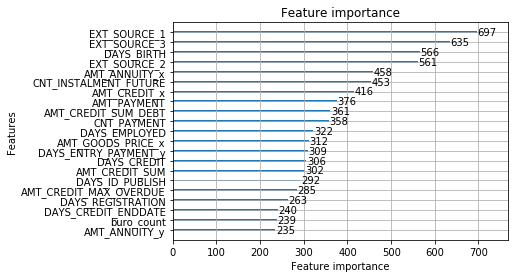

In [5]:
#Plot Variable Importances
%matplotlib inline
lgb.plot_importance(lgbm, max_num_features=21, importance_type='split')